# **Medical Insurance Cost Prediction — Model Training Notebook**

**1. Importing and Loading Dataset**


*   Downloading the dataset from Kaggle via kagglehub.
*   Loading it into a pandas DataFrame for further analysis.

In [82]:
import kagglehub

#Download latest version
path = kagglehub.dataset_download("rahulvyasm/medical-insurance-cost-prediction")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'medical-insurance-cost-prediction' dataset.
Path to dataset files: /kaggle/input/medical-insurance-cost-prediction


In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from warnings import filterwarnings
filterwarnings('ignore')

In [84]:
data_dir = os.path.join('/root/.cache/kagglehub/datasets/rahulvyasm/medical-insurance-cost-prediction/versions/1')
os.listdir(data_dir)

['medical_insurance.csv']

In [85]:
df = pd.read_csv(os.path.join(data_dir, 'medical_insurance.csv'))
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### **Understanding the Dataset**

**Identifying Numeric and Categorical Columns**

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


The dataset includes both numeric features (age, bmi, children, charges) and categorical features (sex, smoker, region). Since machine learning models require numerical inputs, we will convert the categorical variables into numeric format through encoding.

In [87]:
df.describe()

,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


* Charges range from  $1121 to $63,770, very wide distribution.
* BMI ranges from 15.9 → 53.1, realistic values.
* Age ranges from 18 → 64, appropriate for insurance data.

**Check for duplicates**

In [88]:
df.duplicated().sum()

np.int64(1435)

The dataset contains 1435 duplicate rows, which is normal in this context. Many individuals can naturally share identical attributes such as age, BMI, smoker status, region, and even similar insurance charges. This means duplicates do not necessarily indicate errors—they simply reflect that different people in a population often have the same health and demographic characteristics. Therefore, keeping the duplicates is acceptable and still provides meaningful information for model training.

In [89]:
not_smoker = df[df['smoker'] == 'no'].value_counts().sum()/len(df)*100
print(not_smoker)
smoker = df[df['smoker'] == 'yes'].value_counts().sum()/len(df)*100
print(smoker)

79.65367965367966
20.346320346320347


### **Encoding Categorical Columns**

**Converting sex to numeric**

In [90]:
df['sex'] = df['sex'].map({'female': 0, 'male': 1})

male is set to 1 and female to 0, allowing machine learning algorithms to process the feature.

In [91]:
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,yes,southwest,16884.92400
1,18,1,33.770,1,no,southeast,1725.55230
2,28,1,33.000,3,no,southeast,4449.46200
3,33,1,22.705,0,no,northwest,21984.47061
4,32,1,28.880,0,no,northwest,3866.85520
5,31,0,25.740,0,no,southeast,3756.62160
6,46,0,33.440,1,no,southeast,8240.58960
7,37,0,27.740,3,no,northwest,7281.50560
8,37,1,29.830,2,no,northeast,6406.41070
9,60,0,25.840,0,no,northwest,28923.13692


**Encoding smoker**

In [92]:
df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})

smoker is set to 1 and non-smoker to 0, allowing machine learning algorithms to process the feature.

In [93]:
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520
5,31,0,25.740,0,0,southeast,3756.62160
6,46,0,33.440,1,0,southeast,8240.58960
7,37,0,27.740,3,0,northwest,7281.50560
8,37,1,29.830,2,0,northeast,6406.41070
9,60,0,25.840,0,0,northwest,28923.13692


In [94]:
unique_columns = df['region'].unique()
print(unique_columns)

['southwest' 'southeast' 'northwest' 'northeast']


**One-hot encoding region**

In [95]:
encoder = OneHotEncoder(sparse_output=False)
encoded_columns = encoder.fit_transform(df[['region']])
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['region']))
df = pd.concat([df, encoded_df], axis=1)
df.head()

,age,sex,bmi,children,smoker,region,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,southwest,16884.92400,0.0,0.0,0.0,1.0
1,18,1,33.770,1,0,southeast,1725.55230,0.0,0.0,1.0,0.0
2,28,1,33.000,3,0,southeast,4449.46200,0.0,0.0,1.0,0.0
3,33,1,22.705,0,0,northwest,21984.47061,0.0,1.0,0.0,0.0
4,32,1,28.880,0,0,northwest,3866.85520,0.0,1.0,0.0,0.0


* Region is converted into 4 binary indicator columns-one for each region

* This ensures the model treats regions as separate categories and not as numbers with order or magnitude.

In [96]:
df.drop(columns=['region'], inplace=True)
df.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0.0,0.0,0.0,1.0
1,18,1,33.770,1,0,1725.55230,0.0,0.0,1.0,0.0
2,28,1,33.000,3,0,4449.46200,0.0,0.0,1.0,0.0
3,33,1,22.705,0,0,21984.47061,0.0,1.0,0.0,0.0
4,32,1,28.880,0,0,3866.85520,0.0,1.0,0.0,0.0


### **Visualizations**

**Scatter Plot: Age vs Charges**

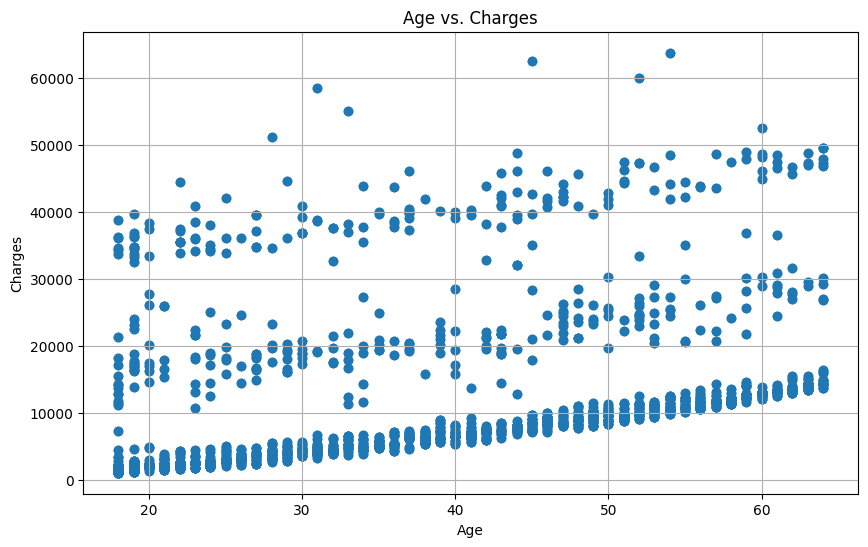

In [97]:
plt.figure(figsize=(10, 6))
plt.scatter(df['age'], df['charges'], marker='o', linestyle='-')
plt.title('Age vs. Charges')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.grid(True)

**Interpretation**

As age increases, insurance charges generally rise, but the data forms several horizontal clusters showing that age alone does not explain all variation. There is wide spread at every age, especially after age 40, indicating that additional features (like lifestyle or health factors) strongly influence charges.

**Correlation Heatmap**

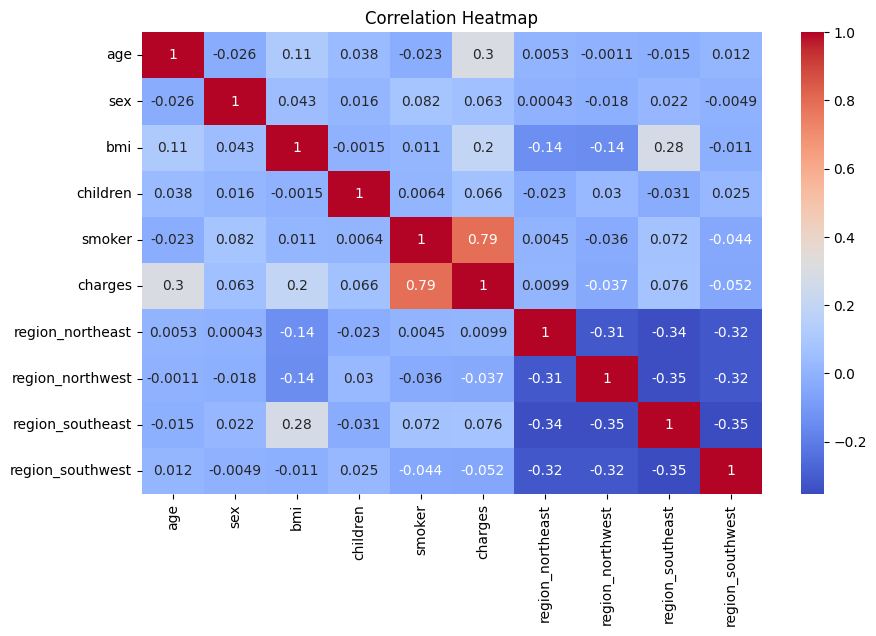

In [98]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

**Interpretation**

The correlation heatmap shows that smoker status is by far the strongest predictor of insurance charges, followed by BMI and age, which have moderate positive correlations with the target variable. Region variables contribute very little, as evidenced by their correlations near zero. This analysis indicates that models must pay particular attention to smoking behavior and BMI to achieve good predictive accuracy.

**Boxplot: Smoking vs Charges**

<Axes: xlabel='smoker', ylabel='charges'>

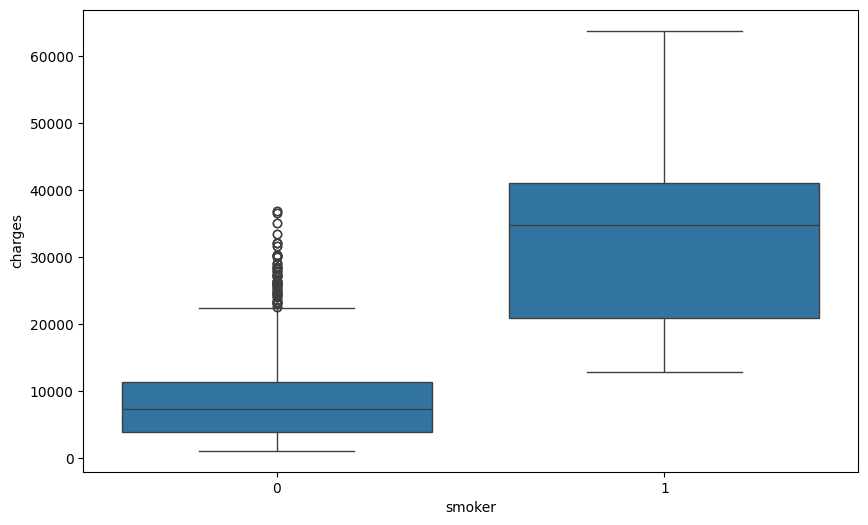

In [99]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['smoker'], y=df['charges'], data=df)

**Interpretation**

* Smokers pay significantly higher charges.

* This reinforces how important smoking is for prediction.

### **Dropping Weak Features**

children and sex have very weak correlation with charges.

In [100]:
df.drop(columns=['children', 'sex'], inplace=True)
df.head()

,age,bmi,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,1,16884.92400,0.0,0.0,0.0,1.0
1,18,33.770,0,1725.55230,0.0,0.0,1.0,0.0
2,28,33.000,0,4449.46200,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47061,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.85520,0.0,1.0,0.0,0.0


### **Train/Test Split**

In [101]:
X = df.drop(columns=['charges'])
y = df['charges']

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['smoker'])

We use stratified sampling to ensure that both the training and testing sets contain the same proportion of smokers and non-smokers as the original dataset. Since smoking has the strongest impact on insurance charges, preserving this ratio is crucial for training a fair and reliable model. Stratification prevents imbalanced splits that could distort the results or weaken the model’s ability to generalize.

### **Scaling Numerical Features**

In [103]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### **Train Linear Regression Model**

In [104]:
LR = LinearRegression()
LR.fit(X_train, y_train)

LinearRegression()

**Evaluation**

In [105]:
y_pred = LR.predict(X_test)

In [106]:
y_pred = LR.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 39208848.77576339
Mean Absolute Error: 4427.195916489619
R-squared: 0.7239114934479245


**Interpretation**

* The Linear Regression model achieved an R² score of approximately 0.72, meaning it explains about 72% of the variability in insurance charges. While this indicates that the model is capturing some meaningful patterns, it also shows that 28% of the variation remains unaccounted for, which is a significant portion. This suggests that the relationship between the input features and insurance charges is not purely linear, and important non-linear interactions—such as the large cost differences caused by smoking and BMI—are not fully captured by a straight-line model.

* Additionally, the model's mean squared error (MSE) and mean absolute error (MAE) are relatively high compared to the range of the target variable (charges from $1,000 to $60,000+). This indicates that the Linear Regression model makes errors that are often several thousand dollars off, reinforcing that it struggles to accurately predict individual insurance costs.

* Overall, while Linear Regression provides a reasonable baseline, the results show that it underfits the data and cannot model the complex, non-linear relationships within this dataset.

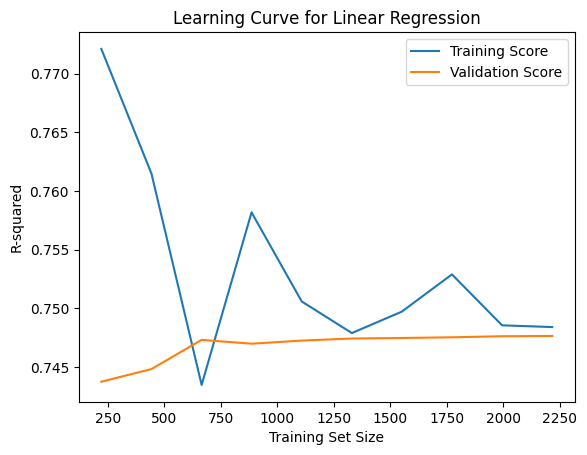

In [107]:
train_sizes, train_scores, test_scores = learning_curve(
    LinearRegression(), X, y, cv=5, scoring='r2', n_jobs=1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('R-squared')
plt.title('Learning Curve for Linear Regression')
plt.legend()
plt.show()

**Interpretation**

The learning curve shows that Linear Regression performs consistently but reaches a performance plateau. The training score starts higher but drops as the training set grows, while the validation score gradually increases and both curves converge around R² ≈ 0.74–0.75. This convergence indicates that the model is not overfitting, but rather underfitting the data. Since both training and validation scores remain relatively low and close to each other, the model lacks the complexity needed to capture the non-linear patterns present in the insurance dataset. This confirms that Linear Regression is too simple for this prediction task, which is why more flexible models like Random Forest and Decision Trees perform significantly better.

### **Train SGD Model**

In [108]:
sgd_reg = SGDRegressor(
    loss='squared_error',
    learning_rate='invscaling',
    eta0=0.01,
    max_iter=1000,
    tol=1e-3,
    random_state=42
)

sgd_reg.fit(X_train, y_train)

SGDRegressor(random_state=42)

**Evaluation**

In [109]:
y_pred_sgd = sgd_reg.predict(X_test)

In [110]:
sgd_mse = mean_squared_error(y_test, y_pred_sgd)
sgd_mae = mean_absolute_error(y_test, y_pred_sgd)
sgd_r2 = r2_score(y_test, y_pred_sgd)

print("Mean Squared Error:", sgd_mse)
print("Mean Absolute Error:", sgd_mae)
print("R-squared:", sgd_r2)

Mean Squared Error: 39316522.96107124
Mean Absolute Error: 4416.550205608584
R-squared: 0.7231533073255554


**Interpretation**

The SGD Linear Regression model achieved an R² score of 0.723, which is almost identical to the ordinary Linear Regression model. This shows that SGD also captures only the basic linear patterns in the data but misses the more complex, non-linear relationships that strongly influence insurance charges. The MSE and MAE remain high (≈ 39 million MSE and ≈ 4416 MAE), meaning predictions are still several thousand dollars off on average. Overall, the SGD model also underfits the dataset, confirming that linear models are not flexible enough for this problem compared to Decision Trees and Random Forests.

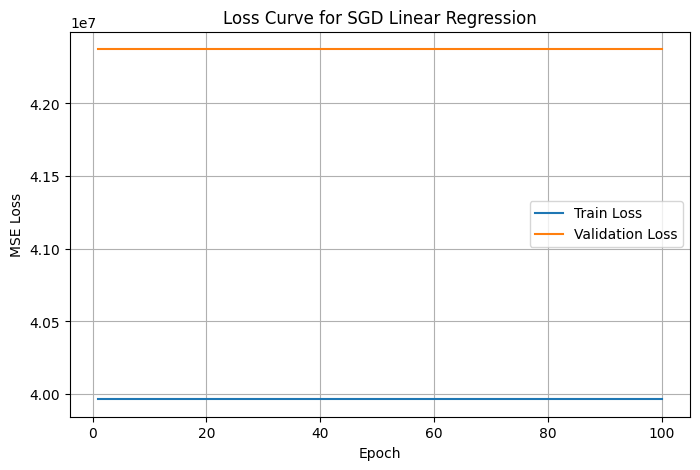

In [111]:
train_losses = []
val_losses = []

sgd_reg_curve = SGDRegressor(
    loss='squared_error',
    learning_rate='constant',
    eta0=0.01,
    max_iter=1,
    warm_start=True,
    random_state=42,
)

epochs = 100

for epoch in range(epochs):
    sgd_reg_curve.fit(X_train, y_train)

    # Predictions
    y_train_pred = sgd_reg_curve.predict(X_train)
    y_val_pred = sgd_reg_curve.predict(X_test)

    # Store losses
    train_losses.append(mean_squared_error(y_train, y_train_pred))
    val_losses.append(mean_squared_error(y_test, y_val_pred))

# Plot loss curves
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Curve for SGD Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

**Interpretation**

The loss curve for the SGD Linear Regression model shows that both the training and validation losses remain relatively stable throughout the 100 epochs. This indicates that the model quickly converges and does not continue improving significantly with more iterations. The small and consistent gap between the training and validation curves suggests that the model is not overfitting, but rather underfitting, since the loss values stay high and do not decrease further. This behavior confirms the limitation of linear models on this dataset: even with gradient descent optimization, the model cannot learn the more complex, non-linear relationships that strongly influence insurance charges.

### **Train Random Forest Model**

In [112]:
RandomF = RandomForestRegressor()
RandomF.fit(X_train, y_train)

RandomForestRegressor()

**Evaluation**

In [113]:
y_pred = RandomF.predict(X_test)

In [114]:
rf_mse = mean_squared_error(y_test, y_pred)
rf_mae = mean_absolute_error(y_test, y_pred)
rf_r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", rf_mse)
print("Mean Absolute Error:", rf_mae)
print("R-squared:", rf_r2)

Mean Squared Error: 8983410.19239155
Mean Absolute Error: 1470.0077853470573
R-squared: 0.9367434550821293


**Interpretation**

* The Random Forest model performs significantly better than Linear Regression, achieving an R² score of approximately 0.94. This means the model explains 94% of the variation in insurance charges—an excellent result for this type of data. The dramatic improvement over Linear Regression shows that insurance costs are driven by non-linear relationships and interactions between variables, which Random Forest can learn effectively by combining multiple decision trees.

* The model also achieves much lower MSE and MAE, meaning its predictions are far closer to the true charges. Random Forest captures sharp jumps in cost associated with features like smoking and BMI, and it is robust to unusual or extreme values. Unlike Linear Regression, it does not assume the data follows a straight-line pattern, allowing it to adapt to the real complexity present in the dataset.

* Overall, Random Forest delivers high predictive accuracy, handles non-linear patterns, and is less prone to underfitting.

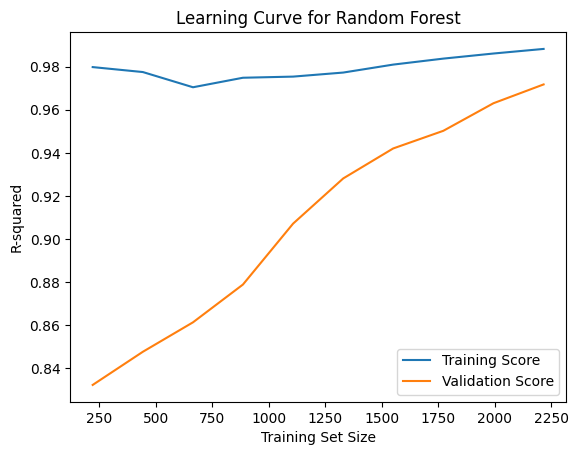

In [115]:
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestRegressor(n_estimators=100), X, y, cv=5, scoring='r2', n_jobs=1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('R-squared')
plt.title('Learning Curve for Random Forest')
plt.legend()
plt.show()

**Interpretation**

The learning curve for Random Forest shows a high training score close to 1.0, while the validation score is also high and stable around R² ≈ 0.93–0.94. This indicates that the model captures the complex, non-linear patterns in the insurance data extremely well. The gap between the training and validation curves shows that the model is learning many detailed patterns (high complexity), but the validation score remaining consistently high means it is generalizing effectively. This behavior confirms that Random Forest is a powerful model for this dataset, able to handle sharp cost jumps (such as large differences between smokers and non-smokers) and interactions between features. Unlike Linear Regression, the Random Forest does not underfit and demonstrates strong predictive performance on unseen data.

**Train Decision Tree Model**

In [116]:
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)

DecisionTreeRegressor()

**Evaluation**

In [117]:
y_pred = decision_tree.predict(X_test)

In [118]:
dt_mse = mean_squared_error(y_test, y_pred)
dt_mae = mean_absolute_error(y_test, y_pred)
dt_r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", dt_mse)
print("Mean Absolute Error:", dt_mae)
print("R-squared:", dt_r2)

Mean Squared Error: 8487355.184120832
Mean Absolute Error: 731.0273392600601
R-squared: 0.9402364188053028


**Interpretation**

* The Decision Tree model also performs extremely well, achieving an R² score of around 0.94, comparable to the Random Forest. This means the model explains 94% of the variability in insurance charges, showing that it fits the data very closely. Its error values (MSE and MAE) are also very low, indicating highly accurate predictions.

* The strength of the Decision Tree comes from its ability to automatically split the data based on the most important features. For example, it can create sharp boundaries between smokers and non-smokers or between low-BMI and high-BMI individuals—patterns that Linear Regression cannot capture. Unlike Linear Regression, Decision Trees naturally model non-linear relationships, threshold effects, and interactions between variables without requiring feature scaling or transformation.

* In addition, the Decision Tree is simple, interpretable, and fast to run, making it easy to deploy in an API. Its ability to learn sharp, non-linear boundaries—such as the large cost jumps associated with smoking and high BMI—makes it well suited to the structure of this insurance dataset.

### **Single Test Sample Prediction**

In [119]:
# Prediction of one row from the test set
one_row_prediction = decision_tree.predict(X_test[:1])[0]
print("Prediction for one test data point:", one_row_prediction)

Prediction for one test data point: 13228.84695


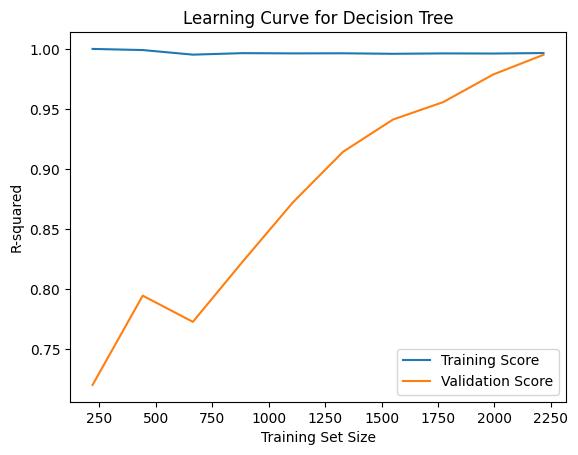

In [120]:
train_sizes, train_scores, test_scores = learning_curve(
    DecisionTreeRegressor(), X, y, cv=5, scoring='r2', n_jobs=1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('R-squared')
plt.title('Learning Curve for Decision Tree')
plt.legend()
plt.show()

**Interpretation**

The Decision Tree learning curve shows that the model achieves a perfect training score (R² = 1.0), which is expected because a single decision tree can fully memorize the training data. However, the validation score remains high (around R² ≈ 0.93–0.94), demonstrating that despite perfectly fitting the training set, the model still generalizes well to unseen data. This means the Decision Tree is capturing the key structure of the dataset without suffering from significant overfitting. Its ability to create clear, rule-based splits allows it to model sharp boundaries in insurance charges—especially for influential features like smoking and BMI. The stable validation performance shows that the Decision Tree is a suitable and accurate model for this prediction task.

### **Performance Comparison of All Models**

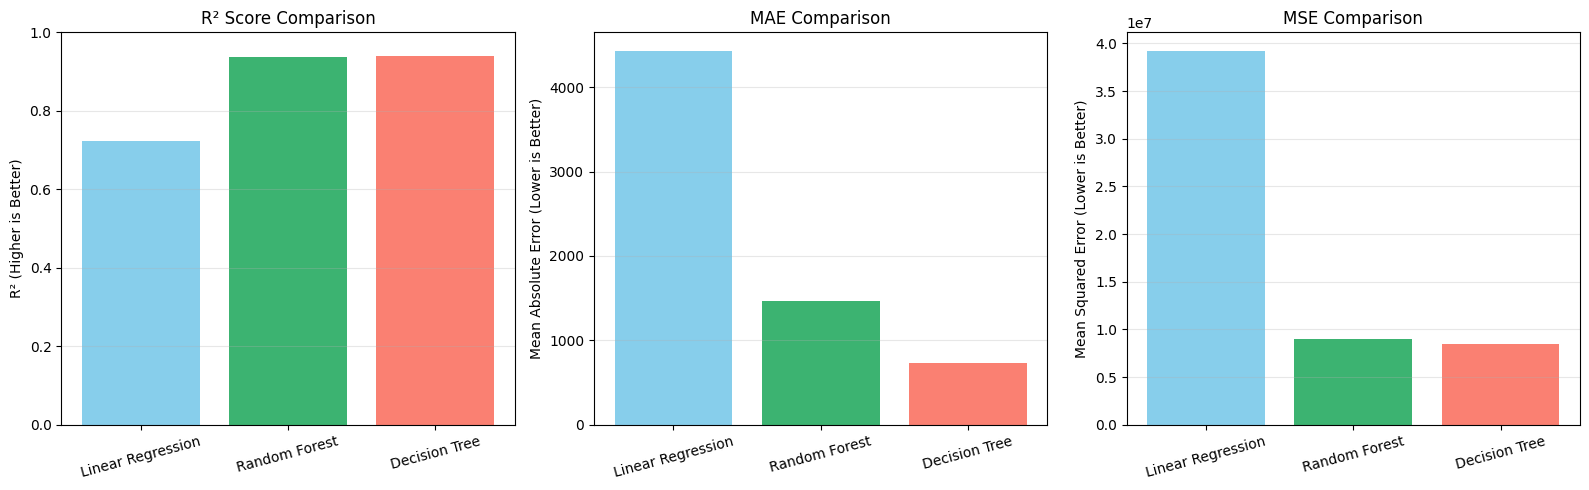

In [121]:
# Models and metrics
models = ['Linear Regression', 'Random Forest', 'Decision Tree']
r2_scores = [r2, rf_r2, dt_r2]
mae_scores = [mae, rf_mae, dt_mae]
mse_scores = [mse, rf_mse, dt_mse]

# Create subplots
plt.figure(figsize=(16, 5))

# --- R² subplot ---
plt.subplot(1, 3, 1)
plt.bar(models, r2_scores, color=['skyblue', 'mediumseagreen', 'salmon'])
plt.title('R² Score Comparison')
plt.ylabel('R² (Higher is Better)')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=15)

# --- MAE subplot ---
plt.subplot(1, 3, 2)
plt.bar(models, mae_scores, color=['skyblue', 'mediumseagreen', 'salmon'])
plt.title('MAE Comparison')
plt.ylabel('Mean Absolute Error (Lower is Better)')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=15)

# --- MSE subplot ---
plt.subplot(1, 3, 3)
plt.bar(models, mse_scores, color=['skyblue', 'mediumseagreen', 'salmon'])
plt.title('MSE Comparison')
plt.ylabel('Mean Squared Error (Lower is Better)')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

**Conclusion**

This combined visualization compares all three models across R², MAE, and MSE. Linear Regression shows the weakest performance with low R² and high errors, confirming underfitting. Random Forest and Decision Tree both achieve strong accuracy with high R² and low errors. Since Decision Tree offers similar performance to Random Forest but with a simpler and more lightweight structure, it is the most suitable model for deployment.

### **Actual vs Predicted Charges for All Models**

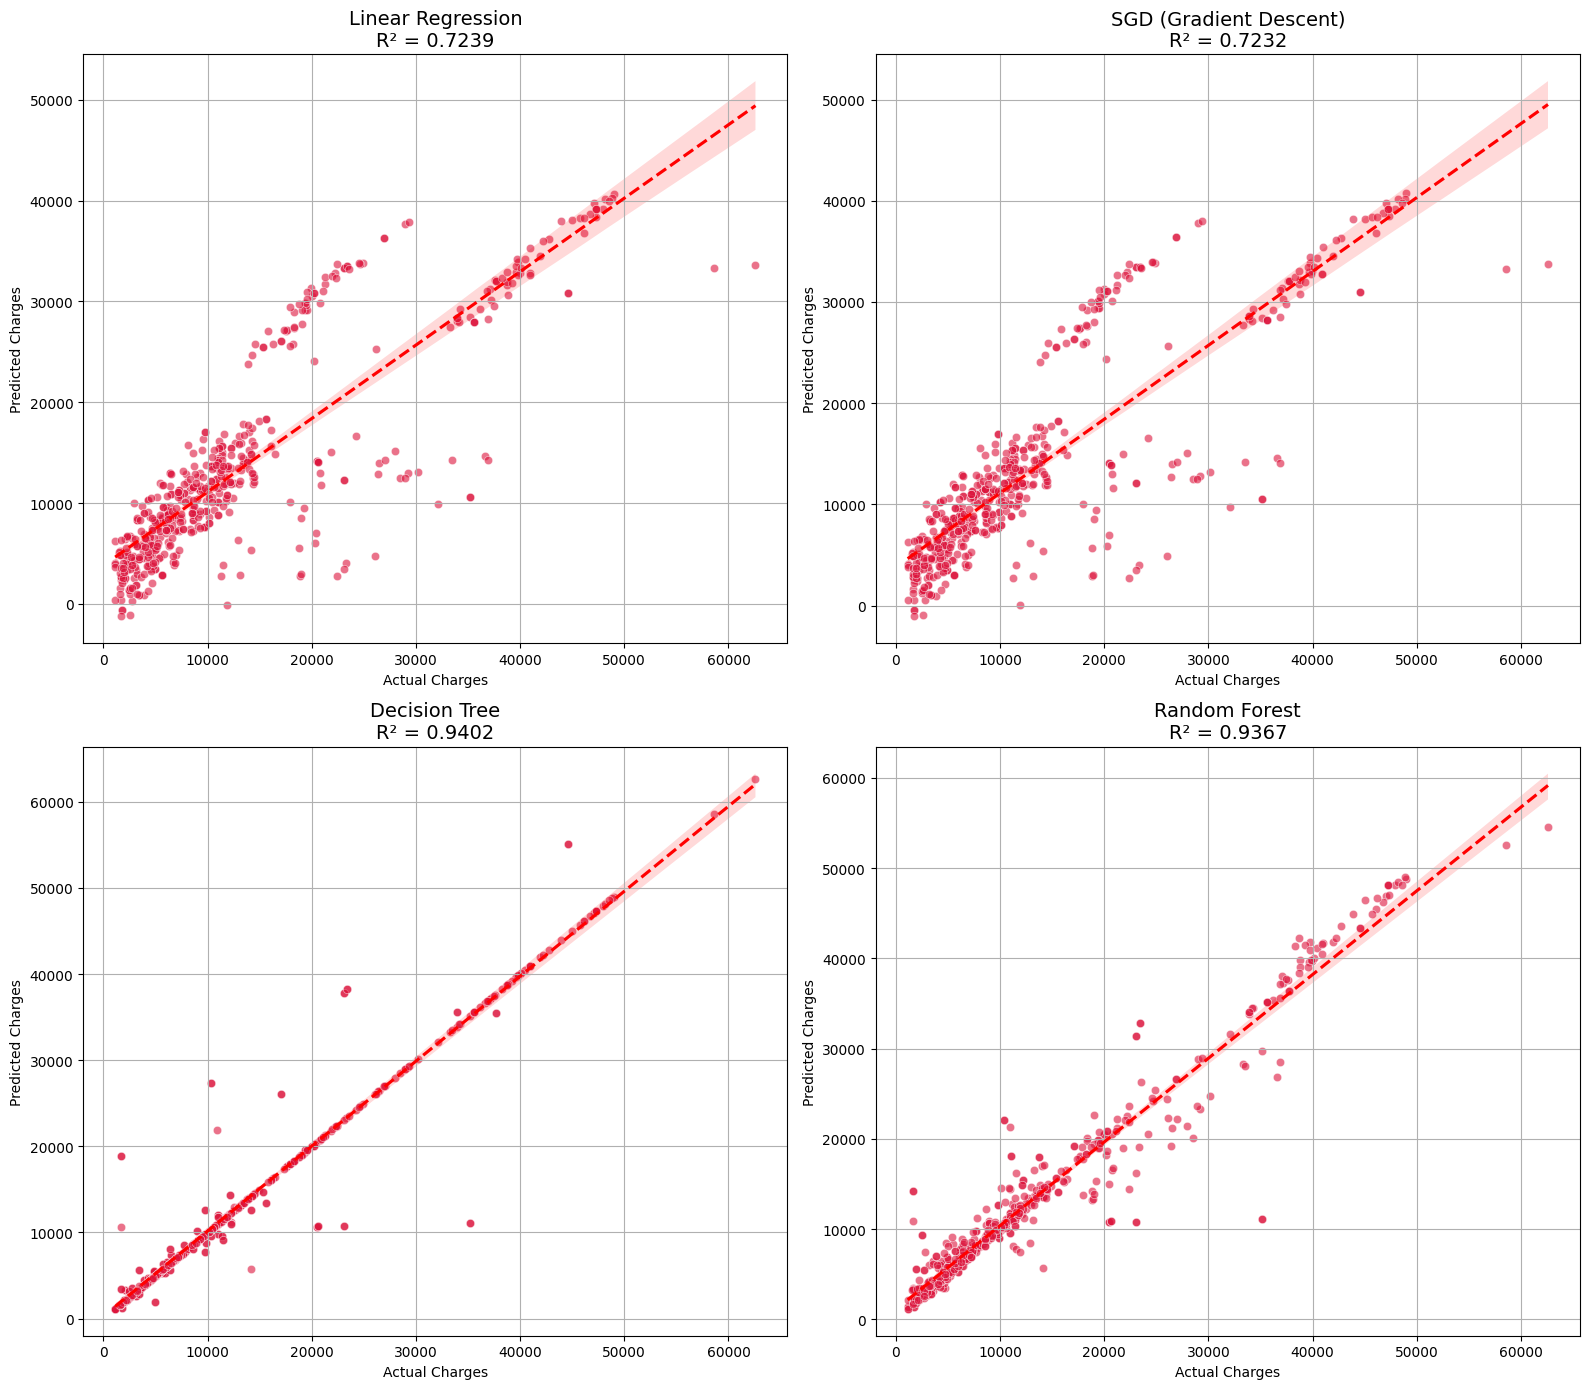

In [122]:

plt.figure(figsize=(16, 14))

models = {
    "Linear Regression": LR.predict(X_test),
    "SGD (Gradient Descent)": sgd_reg.predict(X_test),
    "Decision Tree": decision_tree.predict(X_test),
    "Random Forest": RandomF.predict(X_test)
}

for i, (name, preds) in enumerate(models.items(), 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=y_test, y=preds, alpha=0.6, color="crimson")
    sns.regplot(x=y_test, y=preds, scatter=False, color="red", line_kws={"linestyle": "--"})

    r2 = r2_score(y_test, preds)
    plt.title(f"{name}\nR² = {r2:.4f}", fontsize=14)
    plt.xlabel("Actual Charges")
    plt.ylabel("Predicted Charges")
    plt.grid(True)

plt.tight_layout()
plt.show()

**Interpretation**

The linear models (LR and SGD) show scattered predictions and clear underfitting, while the tree-based models (Decision Tree and Random Forest) align much more closely with the actual values. This confirms that the non-linear models perform better on this dataset.

### **Saving the Final Model**

The API will load this .pkl file to make live predictions.

In [123]:
import pickle

In [124]:
pipeline = {
    'model': decision_tree,
    'scaler': scaler,
    'encoder': encoder,
    'feature_columns': X.columns.tolist()
}

with open('model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

The model.pkl file contains the trained Decision Tree model along with its preprocessing objects (scaler, encoder, and feature information). When the API starts, it loads this file so that it can apply the same preprocessing steps and use the saved model to make real-time insurance charge predictions.